In [2]:
import cv2

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
fn = "./test_imgs/wilfried1.jpg"
input_img = cv2.imread(fn)[..., ::-1]

In [5]:
landmarks_5 = [(380, 139), (354, 136), (292, 124), (319, 129), (332, 175)]

In [6]:
landmarks = np.array(landmarks_5)

In [7]:
landmarks

array([[380, 139],
       [354, 136],
       [292, 124],
       [319, 129],
       [332, 175]])

In [60]:
eye_image_shape = (108, 180)
oh, ow = eye_image_shape

corner1, corner2, is_left = (2, 3, True)
#corner2, corner2, is_left = (0, 1, False)
# left and right eye corners
x1, y1 = landmarks[corner1, :]
x2, y2 = landmarks[corner2, :]
# width of eye
eye_width = 1.5 * np.linalg.norm(landmarks[corner1, :] - landmarks[corner2, :])
# center of eye
cx, cy = 0.5 * (x1 + x2), 0.5 * (y1 + y2)

# center image on middle of eye
translate_mat = np.asmatrix(np.eye(3))
translate_mat[:2, 2] = [[-cx], [-cy]]
inv_translate_mat = np.asmatrix(np.eye(3))
inv_translate_mat[:2, 2] = -translate_mat[:2, 2]

# rotate to be upright
roll = 0.0 if x1 == x2 else np.arctan((y2 - y1) / (x2 - x1))
rotate_mat = np.asmatrix(np.eye(3))
cos = np.cos(-roll)
sin = np.sin(-roll)
rotate_mat[0, 0] = cos
rotate_mat[0, 1] = -sin
rotate_mat[1, 0] = sin
rotate_mat[1, 1] = cos
inv_rotate_mat = rotate_mat.T

# scale
scale = ow / eye_width
scale_mat = np.asmatrix(np.eye(3))
scale_mat[0, 0] = scale_mat[1, 1] = scale
inv_scale = 1.0 / scale
inv_scale_mat = np.asmatrix(np.eye(3))
inv_scale_mat[0, 0] = inv_scale_mat[1, 1] = inv_scale

# center image
centre_mat = np.asmatrix(np.eye(3))
centre_mat[:2, 2] = [[0.5 * ow], [0.5 * oh]]
inv_centre_mat = np.asmatrix(np.eye(3))
inv_centre_mat[:2, 2] = -centre_mat[:2, 2]

transform_mat = centre_mat * scale_mat * rotate_mat * translate_mat
inv_transform_mat = inv_translate_mat * inv_rotate_mat * inv_scale_mat * inv_centre_mat

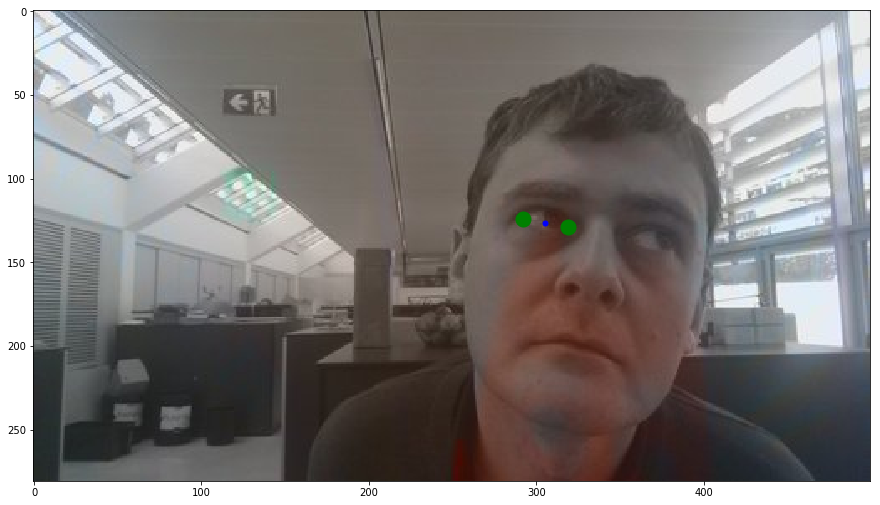

In [61]:
plt.figure(figsize=(15,15))
plt.imshow(input_img)
plt.plot([x1, x2], [y1, y2], 'ro', color='g', markersize=15)
plt.plot([cx], [cy], 'ro', color='b', markersize=5)
plt.show()

In [62]:
eye_image = cv2.warpAffine(input_img, transform_mat[:2, :], (ow, oh))
if is_left:
    eye_image = np.fliplr(eye_image)

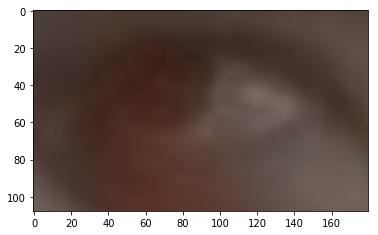

In [63]:
plt.imshow(eye_image)

In [35]:
translate_mat

matrix([[   1. ,    0. , -305.5],
        [   0. ,    1. , -126.5],
        [   0. ,    0. ,    1. ]])

In [91]:
def segment_eyes(frame, landmarks, eye_image_shape = (108, 180)):
    lms = np.array(landmarks)
    eyes = []
    oh, ow = eye_image_shape

    for corner1, corner2, is_left in [(2, 3, True), (0, 1, False)]:
        # left and right eye corners
        x1, y1 = lms[corner1, :]
        x2, y2 = lms[corner2, :]
        # width of eye
        eye_width = 1.5 * np.linalg.norm(lms[corner1, :] - lms[corner2, :])
        # center of eye
        cx, cy = 0.5 * (x1 + x2), 0.5 * (y1 + y2)

        # center image on middle of eye
        translate_mat = np.asmatrix(np.eye(3))
        translate_mat[:2, 2] = [[-cx], [-cy]]
        inv_translate_mat = np.asmatrix(np.eye(3))
        inv_translate_mat[:2, 2] = -translate_mat[:2, 2]

        # rotate to be upright
        roll = 0.0 if x1 == x2 else np.arctan((y2 - y1) / (x2 - x1))
        rotate_mat = np.asmatrix(np.eye(3))
        cos = np.cos(-roll)
        sin = np.sin(-roll)
        rotate_mat[0, 0] = cos
        rotate_mat[0, 1] = -sin
        rotate_mat[1, 0] = sin
        rotate_mat[1, 1] = cos
        inv_rotate_mat = rotate_mat.T

        # scale
        scale = ow / eye_width
        scale_mat = np.asmatrix(np.eye(3))
        scale_mat[0, 0] = scale_mat[1, 1] = scale
        inv_scale = 1.0 / scale
        inv_scale_mat = np.asmatrix(np.eye(3))
        inv_scale_mat[0, 0] = inv_scale_mat[1, 1] = inv_scale

        # center image
        centre_mat = np.asmatrix(np.eye(3))
        centre_mat[:2, 2] = [[0.5 * ow], [0.5 * oh]]
        inv_centre_mat = np.asmatrix(np.eye(3))
        inv_centre_mat[:2, 2] = -centre_mat[:2, 2]

        transform_mat = centre_mat * scale_mat * rotate_mat * translate_mat
        inv_transform_mat = inv_translate_mat * inv_rotate_mat * inv_scale_mat * inv_centre_mat
        
        eye_image = cv2.warpAffine(frame, transform_mat[:2, :], (ow, oh))
        if is_left:
            eye_image = np.fliplr(eye_image)
        
        eyes.append({
                    'image': eye_image,
                    'inv_landmarks_transform_mat': inv_transform_mat,
                    'side': 'left' if is_left else 'right',
                    'corners': [(x1, y1), (x2, y2)]
                })
    return eyes

In [92]:
eyes = segment_eyes(input_img, landmarks_5)

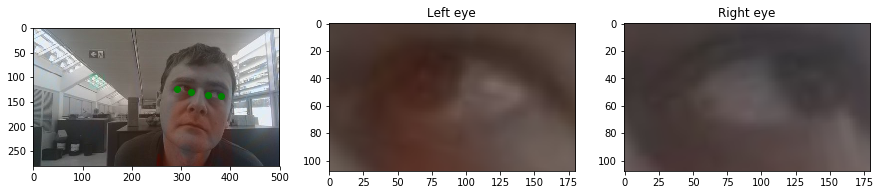

In [94]:
plt.figure(figsize=(15,4))
plt.title('Annotation')
plt.subplot(1,3,1)
plt.imshow(input_img)
xs, ys = zip(*(eyes[0]['corners'] + eyes[1]['corners']))
plt.plot(xs, ys, 'ro', color='g')
plt.subplot(1,3,2)
plt.title('Left eye')
plt.imshow(eyes[0]['image'])
plt.subplot(1,3,3)
plt.title('Right eye')
plt.imshow(eyes[1]['image'])

In [79]:
len(eyes)

1